# Aprendizaje Automatico - TP 1 : Exploración de datos

Vamos a explorar un poco los datos, para familiarizarnos con ellos y ver si pueden aportarnos algun conocimiento valioso.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:g}'.format
plt.rcParams['figure.figsize'] = 14, 5

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.svm import LinearSVC

from scripts.util import *
from scripts.builders import *

In [2]:
train_set, _ = load_processed_data()

Loading Train Set
Done in 0.949000s

Loading Test Set
Done in 0.238000s


Primero inspeccionamos los primeros mails del set de entrenamiento, para ver que pinta tienen.

In [3]:
train_set.head()

,content_types,subject,body,label
0,[text/html],penny st0ck booms on continued demand,\r\n\r\n\r\n\r\n\r\npenny st0ck booms on conti...,spam
1,[text/plain],RE: BNP Paribas Master Netting Agreement,The receivables deal has been terminated. Feel...,ham
2,[text/plain],I NEED YOU TO ACT AS THE NEXT OF KIN TO LATE M...,"\n\n \n \nATTN:THE DIRECTOR /CEO,\n\nAN URGENT...",spam
3,[text/plain],WTI-Brent,Jeff -\nDon't know if WTI-Brent is on the new ...,ham
4,[text/plain],Mrs maureen clark,"\nDear Beloved in Christ,\n\nIt is by the grac...",spam


Tenemos la hipotesis de que saber si un mail tiene contenido html puede ser importante a la hora de determinar si es o no es spam. Vamos a comprobarla.

In [4]:
len_html = float(sum(1 for ct in train_set['content_types'] if 'text/html' in ct ))

len_spam = float(len(train_set[train_set['label'] == 'spam']))
len_ham = float(len(train_set) - len_spam)

print "Cantidad mails spam: ", len_spam
print "Cantidad mails ham: ", len_ham
print "Cantidad mails con html: ", len_html

print "Porcentaje de contenido html en mails: ", len_html / len(train_set), "\n"

sum_spam_html = float(sum(1 for ct in train_set[train_set['label'] == 'spam']['content_types'] if 'text/html' in ct))
print "Cantidad mails spam con html: ", sum_spam_html

sum_ham_html = float(sum(1 for ct in train_set[train_set['label'] == 'ham']['content_types'] if 'text/html' in ct))
print "Cantidad mails ham con html: ", sum_ham_html

print "Porcentaje mails spam con html: ", sum_spam_html / len_spam
print "Porcentaje mails ham con html: ", sum_ham_html / len_ham, "\n"


print "Cantidades: "
print sum_spam_html, "(SpamHTML) ", (len_spam - sum_spam_html),"(SpamNOHTML)"
print sum_ham_html, "(HamHTML) ", (len_ham - sum_ham_html), "(HamNOHTML)", "\n"

print "Matriz porcentajes sobre el total: "
print sum_spam_html / len(train_set), "(SpamHTML) ",  (len_spam - sum_spam_html) / len(train_set), "(SpamNOHTML)"
print sum_ham_html / len(train_set), "(HamHTML)",  (len_ham - sum_ham_html) / len(train_set), "(HamNOHTML)"

Cantidad mails spam:  36003.0
Cantidad mails ham:  35997.0
Cantidad mails con html:  27564.0
Porcentaje de contenido html en mails:  0.382833333333 

Cantidad mails spam con html:  25915.0
Cantidad mails ham con html:  1649.0
Porcentaje mails spam con html:  0.719801127684
Porcentaje mails ham con html:  0.0458093730033 

Cantidades: 
25915.0 (SpamHTML)  10088.0 (SpamNOHTML)
1649.0 (HamHTML)  34348.0 (HamNOHTML) 

Matriz porcentajes sobre el total: 
0.359930555556 (SpamHTML)  0.140111111111 (SpamNOHTML)
0.0229027777778 (HamHTML) 0.477055555556 (HamNOHTML)


Estos valores nos dicen que de una cantidad importante de mails con html es muy poco probable recibir spam sin contenido HTML y análogamente tampoco es muy probable recibir ham con html.
El contenido HTML de un mail parece ser una fuente de información relevante al momento de querer clasificar ham o spam.

Ahora, generaremos la matriz de atributos (unigramas y bigramas) TF-IDF sobre el cuerpo de los mails, y usando dos técnicas de selección de atributos, visualizaremos los 2 atributos más importantes. Las técnicas son:
    - Elegir los 2 atributos que son mas probables(segun un test chi2) que sean dependientes de la etiqueta
    - Entrenar un clasificador SVM lineal con penalización L1(fuerza esparcidad, gran cantidad de pesos en 0), y elegir los 2 atributos que mas importancia tengan
Para visualizar, mostramos un gráfico con el valor de cada uno de los 2 atributos en los ejes, y la clase como color. Tambien mostramos un histograma para cada uno de estos 2 atributos, agrupando por la clase.

In [5]:
def plot_2_best_features(feature_selector_type, tokens, token_names, labels):
    if feature_selector_type == 'k_best':
        transformer = SelectKBest(chi2, k=2)
        selected_tokens = transformer.fit_transform(tokens, labels)
        feature1_name, feature2_name = [token_names[i] for i in transformer.get_support(indices=True)]
    elif feature_selector_type == 'l1':
        svc = LinearSVC(penalty="l1", dual=False).fit(tokens, labels)
        ind = np.argpartition(svc.coef_[0], -2)[-2:]
        ind = ind[np.argsort(svc.coef_[0, ind])][::-1]
        selected_tokens = tokens[:, ind]
        feature1_name, feature2_name = [token_names[i] for i in ind]
    else:
        raise ValueError('Invalid feature_selector_type. Expected \'k_best\' or \'l1\'')

    title = 'Features selected using %s' % feature_selector_type
    
    df = pd.DataFrame(selected_tokens.todense(), columns=[feature1_name, feature2_name])
    df['label'] = labels
    
    df.plot(kind='scatter',
            x=feature1_name,
            y=feature2_name,
            figsize=(10, 5),
            title=title,
            c=['blue' if label == 'ham' else 'red' for label in labels], legend=True)
    
    fig, axs = plt.subplots(ncols=2)
    title = 'Feature \'%s\' frequency by classs'
    
    df.groupby('label')[feature1_name].plot(kind='hist',
                                            ax=axs[0],
                                            title=title % feature1_name,
                                            legend=True, alpha=0.4)
    df.groupby('label')[feature2_name].plot(kind='hist',
                                            ax=axs[1],
                                            title=title % feature2_name,
                                            legend=True, alpha=0.4)
    

def show_selectors_bests_features(X):
    tfidf = TfidfVectorizer(stop_words='english',
                                    ngram_range=(1, 2),
                                    strip_accents='ascii',
                                    sublinear_tf=True)
    tokens = tfidf.fit_transform(X.body)
    token_names = tfidf.get_feature_names()
    plot_2_best_features('k_best', tokens, token_names, X.label)
    plot_2_best_features('l1', tokens, token_names, X.label)

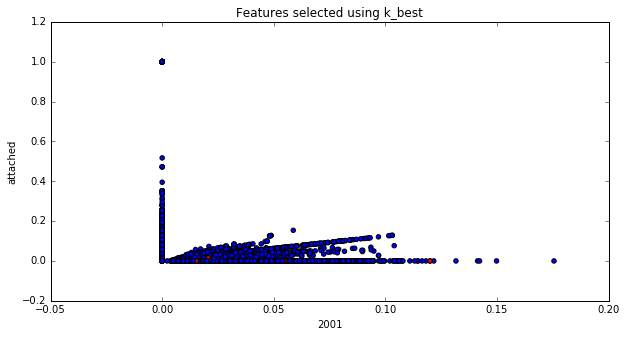

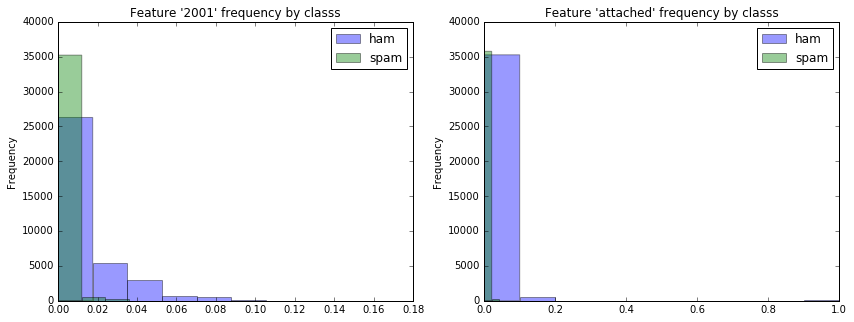

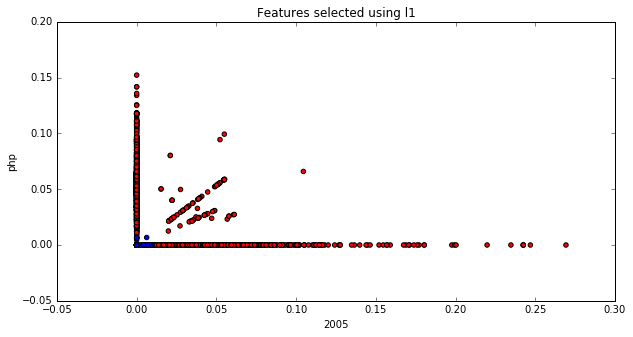

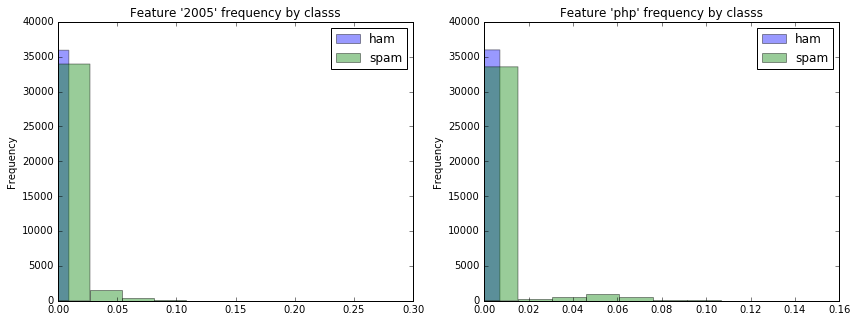

In [6]:
show_selectors_bests_features(train_set)

## Conclusiones

Los gráficos muestran distinto nivel de relación entre la frecuencia de las features y la clase a la que pertenecen.

Se logra distinguir un poco más en el caso de L1 que en el de K-best2 un comportamiento distinto dependiendo de la clase, teniendo frecuencia casi nula en los mails de ham y un poco más distribuida en spam. En ambos casos es poca la información que brindan estas features para dar una idea de como se comportan los mails de cada clase.